In [1]:
import pandas as pd
import numpy as np
from dbfread import DBF
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Análisis de los nuevos datos de homicidios del año 2024. 

En este notebook realizaré las siguientes actividades
* Leer y limpiar los datos descargados, enfocándome únicamente en presuntos homicidios 

* Realizar un análisis exploratorio de los datos de homicidios e identificar tres hallazgos importantes que te gustaría destacar. Considera que los hallazgos serán para un blog sobre el análisis de la violencia (por ejemplo, con perspectiva de género y un enfoque en comunidades racializadas y/o migrantes). 

__Transformamos las bases de datos de dbf a csv con la libreria dbfread__

In [77]:
dir_dbf = './defunciones_base_datos_2024_dbf/*.dbf'
archivo_dbf_list = glob.glob(dir_dbf)
for dbf in archivo_dbf_list:
    tabla = DBF(dbf, encoding='cp850')
    df = pd.DataFrame(list(tabla))
    df.to_csv(dbf[:-3]+'csv', index=False, encoding='cp850')

__Ahora, leemos la tabla con los registros de de Defuncionesy los catálogos necesarios__

In [2]:
DEFUN24 = pd.read_csv('./defunciones_base_datos_2024_dbf/DEFUN24.csv', low_memory=False)
CATMINDE = pd.read_csv('./defunciones_base_datos_2024_dbf/CATMINDE.csv', low_memory=False, encoding='cp850')
PARENTESCO = pd.read_csv('./defunciones_base_datos_2024_dbf/PARENTESCO.csv', low_memory=False, encoding='cp850')

__Revisamos las columnas de la tabla de defunciones para su selección__

In [3]:
DEFUN24.columns

Index(['ENT_REGIS', 'MUN_REGIS', 'TLOC_REGIS', 'LOC_REGIS', 'ENT_RESID',
       'MUN_RESID', 'TLOC_RESID', 'LOC_RESID', 'ENT_OCURR', 'MUN_OCURR',
       'TLOC_OCURR', 'LOC_OCURR', 'CAUSA_DEF', 'COD_ADICIO', 'LISTA_MEX',
       'SEXO', 'ENT_NAC', 'AFROMEX', 'CONINDIG', 'LENGUA', 'CVE_LENGUA',
       'NACIONALID', 'NACESP_CVE', 'EDAD', 'SEM_GEST', 'GRAMOS', 'DIA_OCURR',
       'MES_OCURR', 'ANIO_OCUR', 'DIA_REGIS', 'MES_REGIS', 'ANIO_REGIS',
       'DIA_NACIM', 'MES_NACIM', 'ANIO_NACIM', 'COND_ACT', 'OCUPACION',
       'ESCOLARIDA', 'EDO_CIVIL', 'TIPO_DEFUN', 'OCURR_TRAB', 'LUGAR_OCUR',
       'PAR_AGRE', 'VIO_FAMI', 'ASIST_MEDI', 'CIRUGIA', 'NATVIOLE',
       'NECROPSIA', 'USONECROPS', 'ENCEFALICA', 'DONADOR', 'SITIO_OCUR',
       'COND_CERT', 'DERECHOHAB', 'EMBARAZO', 'REL_EMBA', 'HORAS', 'MINUTOS',
       'CAPITULO', 'GRUPO', 'LISTA1', 'GR_LISMEX', 'AREA_UR', 'EDAD_AGRU',
       'COMPLICARO', 'DIA_CERT', 'MES_CERT', 'ANIO_CERT', 'MATERNAS',
       'ENT_OCULES', 'MUN_OCULES', 'LOC_OCUL

# Hallazgo 1

## Relación entre víctimas y victimarios

__Seleccionamos las columnas de interes__

In [4]:
# Selección de columnas
columnas = [
    'TIPO_DEFUN',
    'SEXO',
    'PAR_AGRE',
]
DEFUN24_seleccion = DEFUN24[columnas]

# Seleccionamos solo los homicidios y descartamos los registros 
# que no indican una relación entre víctimas y victimarios,
# Ádemas, usamos el catálogo de PARENTESCO para nombrar las relaciones

Homicidios_x_agresor = pd.merge(
    DEFUN24[
        (DEFUN24_seleccion['TIPO_DEFUN'] == 2)&
        (~DEFUN24_seleccion['PAR_AGRE'].isin([ 71,72, 88, 98, 99]))
    ][['SEXO','PAR_AGRE']],
    PARENTESCO.rename(columns={'CVE':'PAR_AGRE'}),
    on='PAR_AGRE',
    how='inner'
).groupby(['DESCRIP','SEXO']).count().reset_index()
Homicidios_x_agresor

,DESCRIP,SEXO,PAR_AGRE
0,Amigo,1,4
1,Amigo,2,1
2,"Concubino, compañero",2,7
3,Conocido,1,1
4,Conocido,2,1
5,Cuñado,1,4
6,"Esposa, Cónyuge",1,3
7,"Esposo, Cónyuge",1,1
8,"Esposo, Cónyuge",2,5
9,Ex esposo,2,2


__Conteo de homicidios perpetuados por allegados a la víctima__

In [5]:
print("="*40)
print("Homicidios totales: ",Homicidios_x_agresor['PAR_AGRE'].sum())
print("Homicidios totales en  mujeres: ",Homicidios_x_agresor[Homicidios_x_agresor['SEXO'] == 2]['PAR_AGRE'].sum())
print("Homicidios totales en  hombres: ",Homicidios_x_agresor[Homicidios_x_agresor['SEXO'] == 1]['PAR_AGRE'].sum())
print("="*40)

Homicidios totales:  74
Homicidios totales en  mujeres:  32
Homicidios totales en  hombres:  42


__Hacemos una tabla pivote donde los reglones indiquen el sexo y las columnas cada relación__

In [6]:
pivoteo = pd.pivot_table(
    Homicidios_x_agresor,
    index='SEXO',      
    columns='DESCRIP',
    values='PAR_AGRE',
    aggfunc='sum',
    fill_value=0
)
pivoteo = pivoteo.T.reset_index().sort_values([2,1]).T
pivoteo

,7,13,14,15,4,3,16,17,18,20,...,9,19,0,8,6,11,12,5,10,1
SEXO,,,,,,,,,,,,,,,,,,,,,
DESCRIP,Hermana,Otro familiar,Padrastro,Padre,"Esposa, Cónyuge",Cuñado,Primo,Sobrino,Tío,Yerno,...,Hija,Vecino,Amigo,Hermano,Ex esposo,Madre,Nieto,"Esposo, Cónyuge",Hijo,"Concubino, compañero"
1,1,1,2,2,3,4,4,5,0,0,...,1,3,4,4,0,1,2,1,3,0
2,0,0,0,0,0,0,0,0,1,1,...,1,1,1,1,2,2,3,5,6,7


__Guardamos la tabla anterior en un csv__

In [7]:
pivoteo.to_csv('resultado.csv', encoding='cp850')

Hice una gráfica de radar usando [flourish](https://flourish.studio/), sin embargo, tengo solo una cuenta fratuita lo que me impide descargar las gráficas como imagenes, por lo cual opté por tmar una captura de pantalla.

<img src="./graficos/radar.png" width="400px">

# Hallazgo 2

## Distribución de homicidios por edad en grupos de sexo

In [8]:
def edad(x):
    """
    Transforción de la clave de edad a número
    """
    if x<4000:
        return 0
    elif x<4990:
        return x-4000
    else:
        return None

# Selección de columnas
columnas = [
    'TIPO_DEFUN',
    'SEXO',
    'NACIONALID',
    'AREA_UR',
    'EDAD'
]
DEFUN24_seleccion = DEFUN24[columnas]

# Homicidios de Mujeres
Homicidios_mujeres = DEFUN24_seleccion[
    (DEFUN24_seleccion['TIPO_DEFUN'] == 1)&
    (DEFUN24_seleccion['SEXO'] == 2)
].copy()
Homicidios_mujeres['EDAD'] = Homicidios_mujeres['EDAD'].apply(edad)           # transformación de edad
Homicidios_mujeres = Homicidios_mujeres[~Homicidios_mujeres['EDAD'].isna()]   # quitar edades no especificadas
Homicidios_mujeres = Homicidios_mujeres[Homicidios_mujeres['SEXO']!=9]        # quitar sexo no especificados

# Homicidios de Hombres
Homicidios_Hombres = DEFUN24_seleccion[
    (DEFUN24_seleccion['TIPO_DEFUN'] == 1)&
    (DEFUN24_seleccion['SEXO'] == 1)
].copy()
Homicidios_Hombres['EDAD'] = Homicidios_Hombres['EDAD'].apply(edad)
Homicidios_Hombres = Homicidios_Hombres[~Homicidios_Hombres['EDAD'].isna()]
Homicidios_Hombres = Homicidios_Hombres[Homicidios_Hombres['SEXO']!=9]

__Construcción del gráfico__

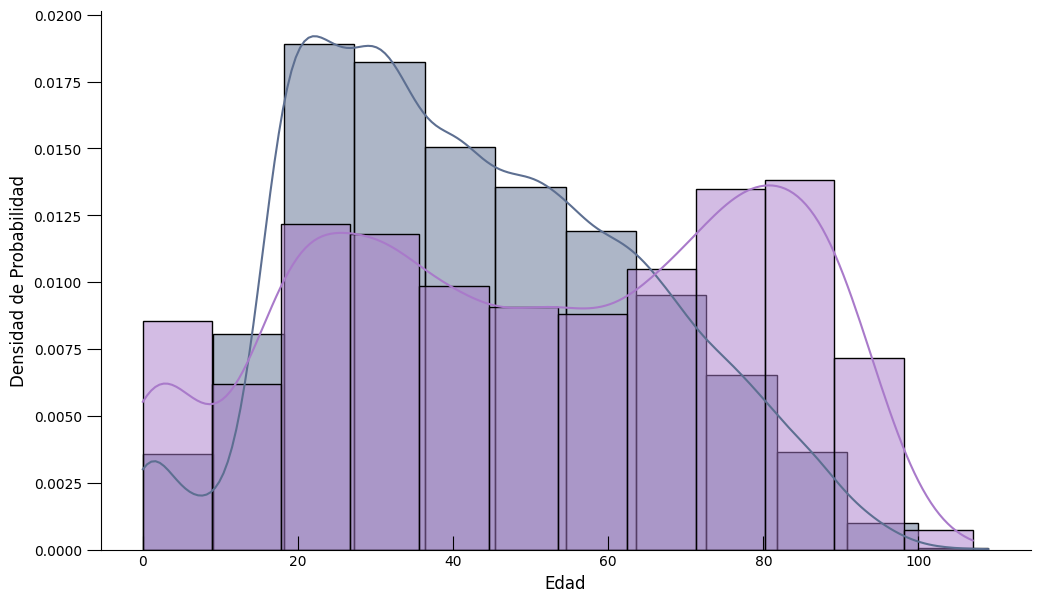

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crearmos el Histograma con Curva de Densidad
plt.figure(figsize=(12, 7))
ax = plt.gca() 

# Distribución de Mujeres
sns.histplot(
    Homicidios_Hombres['EDAD'], 
    ax=ax,                
    stat='density',        
    bins=12,              
    kde=True,
    color='#5d6f91',
    alpha=0.5,
    label='Hombres',
)

# Distribución de Hombres
sns.histplot(
    Homicidios_mujeres['EDAD'], 
    ax=ax,                
    stat='density',        
    bins=12,               
    kde=True,              
    color='#a97aca',
    alpha=0.5,             
    label='Mujeres',
)

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', direction='in', length=10)
ax.tick_params(axis='y', length=10)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Densidad de Probabilidad', fontsize=12)
plt.savefig('./graficos/densidad.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

# Hallazgo 3

## Distribución espacial (por municipio) de los homicidios a personas de nacionalidad no mexicanas

In [10]:
# Selección de columnas
columnas = [
    'TIPO_DEFUN',
    'SEXO',
    'NACIONALID',
    'ENT_OCURR',
    'MUN_OCURR',
    "NACESP_CVE",
    'CAUSA_DEF',
    'AREA_UR'
]
DEFUN24_seleccion = DEFUN24[columnas]

# Seleccionamos los homicidos a personas extranjeras 
# y las distintas entidades de ocurrencia
DEFUN24_seleccion = DEFUN24_seleccion[
  (DEFUN24['TIPO_DEFUN'] == 2)&
  (DEFUN24['NACIONALID'] != 1)&
  (DEFUN24['ENT_OCURR'] != 99)
].copy()

# Hacemos el conteo de homicidios por municipio
DEFUN24_por_entidad = DEFUN24_seleccion[['TIPO_DEFUN','ENT_OCURR','MUN_OCURR']].groupby(['ENT_OCURR','MUN_OCURR']).count().reset_index()
DEFUN24_por_entidad = DEFUN24_por_entidad.rename(columns={'ENT_OCURR':'CVE_ENT','MUN_OCURR':'CVE_MUN'})

__Suma total de Homicidios a personas de nacionalidad no mexicana__

In [11]:
print('Total de homicidios: ', DEFUN24_por_entidad['TIPO_DEFUN'].sum())

Total de homicidios:  3406


__Importamos las figuras de los municipios y estados (informaciónd de: [@pwrose](https://github.com/sbl-sdsc/mexico-boundaries))__

In [12]:
# Importar Estados de México
gdf = gpd.read_parquet("geo/mexico_admin1.parquet")
gdf_estados = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf_estados['CVE_ENT'] = gdf_estados['CVE_ENT'].astype(int)
gdf_estados = gdf_estados.to_crs("EPSG:32613")

# Importar Municipios de México
gdf = gpd.read_parquet("geo/mexico_admin2.parquet")
gdf_municipios = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf_municipios = gdf_municipios.to_crs("EPSG:32613")
gdf_municipios['CVE_ENT'] = gdf_municipios['CVE_ENT'].astype(int)
gdf_municipios['CVE_MUN'] = gdf_municipios['CVE_MUN'].astype(int)

gdf_municipios = gdf_municipios.merge(DEFUN24_por_entidad,on=['CVE_ENT','CVE_MUN'],how='inner')

__Construcción del mapa__

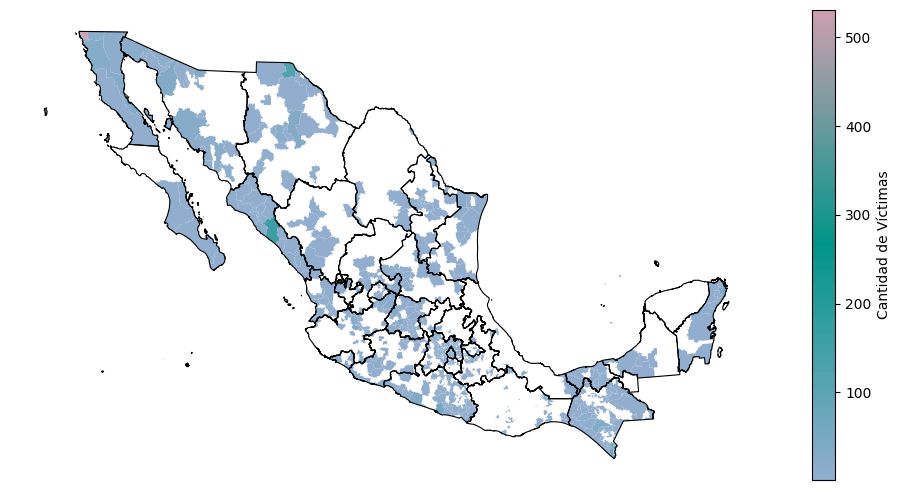

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.gca()

# Crear barra de colores
cpm_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#92aecf","#009589","#cd9faf"])
sm = ScalarMappable(cmap=cpm_cmap, norm=Normalize(
    vmin=gdf_municipios['TIPO_DEFUN'].min(),
    vmax=gdf_municipios['TIPO_DEFUN'].max()
))
sm._A = [] 

# Graficar municipios
gdf_municipios.plot(ax=ax, column="TIPO_DEFUN", cmap=cpm_cmap, edgecolor=None)
gdf_estados.boundary.plot(ax=ax, color="k", linewidth=0.8)

# Agregar la barra de color al gráfico
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Cantidad de Víctimas') 

ax.axis('off')
plt.tight_layout()
#fig.savefig('./graficos/mapa.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

__Top 5 de homicidios por municipio__

In [14]:
gdf_municipios.sort_values('TIPO_DEFUN',ascending=False).head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,TIPO_DEFUN
7,02004,2,4,Tijuana,"MULTIPOLYGON (((-655176.209 3653109.342, -6551...",531
474,25006,25,6,Culiacán,"POLYGON ((281536.349 2795311.465, 283656.384 2...",156
103,08037,8,37,Juárez,"POLYGON ((357037.376 3514958.461, 357054.906 3...",121
158,12001,12,1,Acapulco de Juárez,"MULTIPOLYGON (((1043318.809 1866948.513, 10434...",68
72,07089,7,89,Tapachula,"POLYGON ((1886573.655 1724538.422, 1886916.524...",66


__Principales nacionalidades de las personas__

In [15]:
nac = DEFUN24_seleccion[['NACESP_CVE','TIPO_DEFUN']].groupby('NACESP_CVE').count().reset_index()
nac[nac['TIPO_DEFUN']>10]

,NACESP_CVE,TIPO_DEFUN
6,214,54
8,216,12
10,220,19
11,221,160
12,225,52
14,229,60
18,250,19
26,999,2981


__Principales causas de defunción__

Nota: A la descripción de defunción se le quitó su última parte (despues de la coma) para ver solo el tipo de agresión. 

In [16]:
causa = DEFUN24_seleccion[['CAUSA_DEF','TIPO_DEFUN']].groupby('CAUSA_DEF').count().reset_index()
causa = causa.merge(CATMINDE.rename(columns={'CVE':'CAUSA_DEF'}),on='CAUSA_DEF',how='left')

causa['DESCRIP'] = causa['DESCRIP'].apply(lambda x: x.split(',')[0])
causa[['DESCRIP','TIPO_DEFUN']].groupby('DESCRIP').sum().reset_index()

,DESCRIP,TIPO_DEFUN
0,AGRESION CON DISPARO DE ARMA CORTA,4
1,AGRESION CON DISPARO DE OTRAS ARMAS DE FUEGO,1763
2,AGRESION CON DISPARO DE RIFLE,3
3,AGRESION CON DROGAS,1
4,AGRESION CON FUERZA CORPORAL,7
5,AGRESION CON GASES Y VAPORES,2
6,AGRESION CON HUMO,61
7,AGRESION CON MATERIAL EXPLOSIVO,4
8,AGRESION CON OBJETO CORTANTE,341
9,AGRESION CON OBJETO ROMO O SIN FILO,65
